# Author: Tim Harmling and Alexej Kravtschenko
- **Note:** This notebook was written by the combined effort of Tim Harmling and Alexej Kravtschenko 
- **Description:** Automatic Workflow to Transfer Learn the Handwriting Model

In [1]:
#import handwriting.load_data as load_data
import load_transfer_data
import models as models # Use: build_model9v3(img_width, img_height, char) 
import utils.configs as cfg
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import pickle
import time
import os
import re


0_0
0_1
0_11
0_2
0_3
0_4
0_5
0_6
0_7
0_8
0_9
10_10
10_11
10_12
10_13
10_14
10_16
10_5
10_6
10_7
10_8
10_9
11_0
11_10
11_11
11_12
11_13
11_15
11_5
11_6
11_7
11_8
11_9
12_0
12_10
12_11
12_12
12_13
12_14
12_15
12_6
12_7
12_8
12_9
13_10
13_11
13_12
13_15
13_2
13_5
13_6
13_7
13_8
13_9
14_10
14_11
14_12
14_13
14_3
14_5
14_6
14_7
14_8
14_9
15_10
15_11
15_12
15_13
15_14
15_3
15_6
15_7
15_8
15_9
16_10
16_11
16_12
16_13
16_14
16_4
16_6
16_7
16_8
16_9
17_0
17_1
17_11
17_13
17_14
17_15
17_16
17_2
17_3
17_4
17_9
18_0
18_10
18_11
18_12
18_13
18_14
18_16
18_6
18_7
18_8
18_9
19_0
19_1
19_10
19_11
19_12
19_13
19_15
19_16
19_2
19_4
19_8
1_0
1_10
1_11
1_2
1_3
1_4
1_5
1_6
1_7
1_8
1_9
20_11
20_12
20_13
20_16
20_2
20_3
20_4
20_5
20_7
20_8
20_9
21_11
21_12
21_13
21_16
21_2
21_3
21_4
21_5
21_7
21_8
21_9
22_11
22_12
22_13
22_16
22_2
22_3
22_4
22_5
22_7
22_8
22_9
23_11
23_12
23_13
23_16
23_2
23_3
23_4
23_5
23_7
23_8
23_9
24_0
24_1
24_16
24_2
24_3
24_4
24_5
24_6
24_7
24_8
25_0
25_1
25_16
25_2
25_3
25_4
25_5
25_6

## Config

In [2]:
config_path = "utils\configs.json"

config = cfg.Config(config_path)

# Pipeline
#TRANSFER = bool(config.get_pipeline_parameter()["transfer"])

# Model Parameter
MODEL_SAVE = bool(config.get_model_parameter()["save"])
MODEL_NAME = config.get_model_parameter()["name"]
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

# Directory Parameter
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["model_dir"])
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["test_dir"])
DATA_BASE_PATH = config.get_directory_parameter()["data_base_path"]

# Training Parameter
SAVE_HISTORY = bool(config.get_training_parameter()["save_history"])
EPOCHS = config.get_training_parameter()["epochs"]
BATCH_SIZE = config.get_training_parameter()["batch_size"] # default: 32 - 48
TF_SEED = config.get_training_parameter()["tf_seed"] # default: 42
LEARNING_RATE = config.get_training_parameter()["learning_rate"]
PATIENCE = config.get_training_parameter()["patience"] # default: 3

## Load Data

In [3]:
x_train_img_paths, y_train_labels = load_transfer_data.get_train_data()
x_val_img_paths, y_val_labels = load_transfer_data.get_validation_data()

In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
#print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['dataset/dataset_training/handwriting_dataset/dataset\\0_0.jpg', 'dataset/dataset_training/handwriting_dataset/dataset\\0_1.jpg'] ['Lüdtke', 'Markus']
Validation path: ['dataset/dataset_training/handwriting_dataset/dataset\\71_4.jpg', 'dataset/dataset_training/handwriting_dataset/dataset\\71_5.jpg'] ['Silvester', '6B']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer as tokenizer

# train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
# val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)

## Show Examples

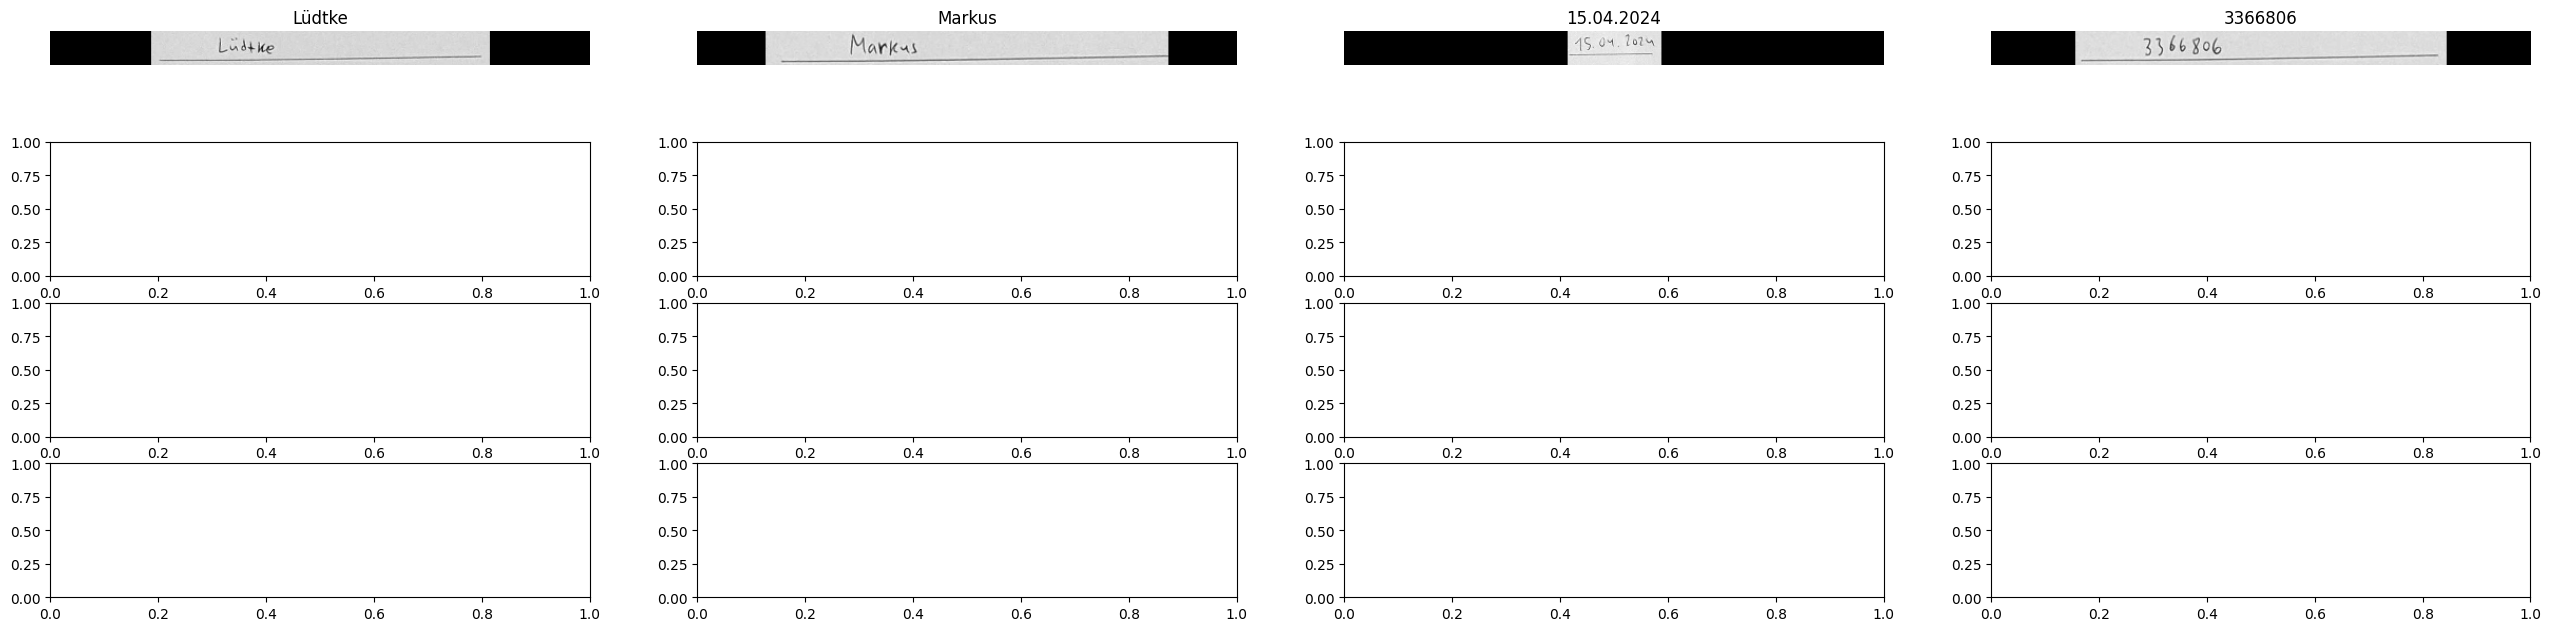

In [8]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()  

# Train Keras Model

In [9]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    """Loads model weights if they exist.

    This function checks if the model weights exist and loads them into the model.

    Args:
        model: The Keras model.

    Returns: 
        None
    """
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [11]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    #model_load_weights_if_exists(model)
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-9, verbose=2) 
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[reduce_lr, early_stopping])  
     
    return prediction_model, history

# Transfer Model

In [12]:
def load_model_and_weights():
    """Loads a pre-trained model and its weights.

    This function, loads a pre-trained model and its weights
    from the specified directory. It checks if both the model and weights exist before loading.

    Returns:
        model: The pre-trained Keras model with loaded weights, if found. Default: model9v3_xl
    """
    weights_keras_string = "_weights.keras"
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    model_weight_path = "models\old_goat\old_goat_weights.keras"
    model_path = "models\old_goat"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [13]:
model = load_model_and_weights()
max_len = len(tokenizer.char_to_num.get_vocabulary())
characters = tokenizer.char_to_num.get_vocabulary()
model.summary()

models\old_goat
Loading pre-trained model and weights...
Model and weights loaded successfully.
Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 1024, 128,   0           []                               
                                1)]                                                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 1024, 128, 4  480         ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 Conv2 (Conv2D)                 (None, 1024, 128, 9  41568       ['Conv1[0][0]']

In [14]:
data_to_save = (max_len, characters)

with open('saved_handwriting_model_characters.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [ ]:
#model = models.load_and_finetune_model_dense(model, max_len, LEARNING_RATE)

In [ ]:
# Should be skipped if model "model9v3_xl" is loaded
#model = load_model("../models/only_numbers")
#model.load_weights("../models/only_numbers/only_numbers_weights.keras")    

In [15]:
train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
# train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)
# val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)

In [16]:
for layer in model.layers:
    layer.trainable = False

In [17]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100
147/147 [==============================] - 25s 95ms/step - loss: 46.8906 - val_loss: 28.5088 - lr: 2.0000e-04
Epoch 2/100
147/147 [==============================] - 12s 81ms/step - loss: 29.6400 - val_loss: 23.5882 - lr: 2.0000e-04
Epoch 3/100
147/147 [==============================] - 12s 82ms/step - loss: 26.3705 - val_loss: 21.4942 - lr: 2.0000e-04
Epoch 4/100
147/147 [==============================] - 11s 78ms/step - loss: 24.7188 - val_loss: 19.4915 - lr: 2.0000e-04
Epoch 5/100
147/147 [==============================] - 11s 77ms/step - loss: 23.5280 - val_loss: 18.6424 - lr: 2.0000e-04
Epoch 6/100
147/147 [==============================] - 12s 81ms/step - loss: 22.2109 - val_loss: 17.7130 - lr: 2.0000e-04
Epoch 7/100
147/147 [==============================] - 12s 81ms/step - loss: 21.0385 - val_loss: 16.1805 - lr: 2.0000e-04
Epoch 8/100
147/147 [==============================] - 12s 82ms/step - loss: 19.7940 - val_loss: 14.6931 - lr: 2.0000e-04
Epoch 9/100
147/147 [===


# Plot helper functions

In [19]:
def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.
    
    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    #ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [20]:
# Creates a directory if it doesn't exist
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [21]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_transfer_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [22]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

In [23]:
def create_new_plot_name(model_name, names, format):
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    
    return format.replace(model_name,new_model_name)

# Model Testing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


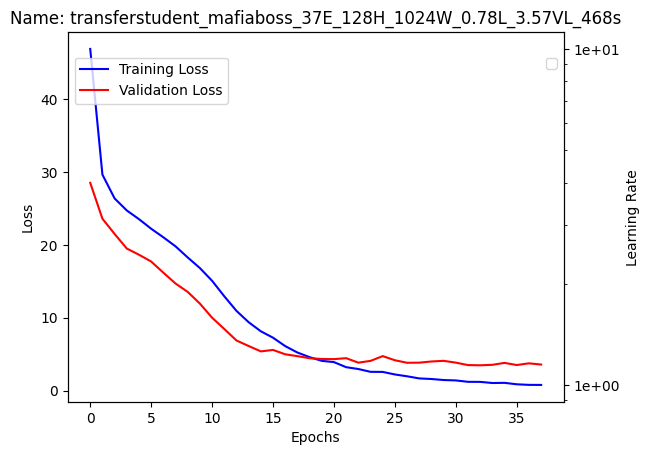

1/1 [==============================] - 1s 1s/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

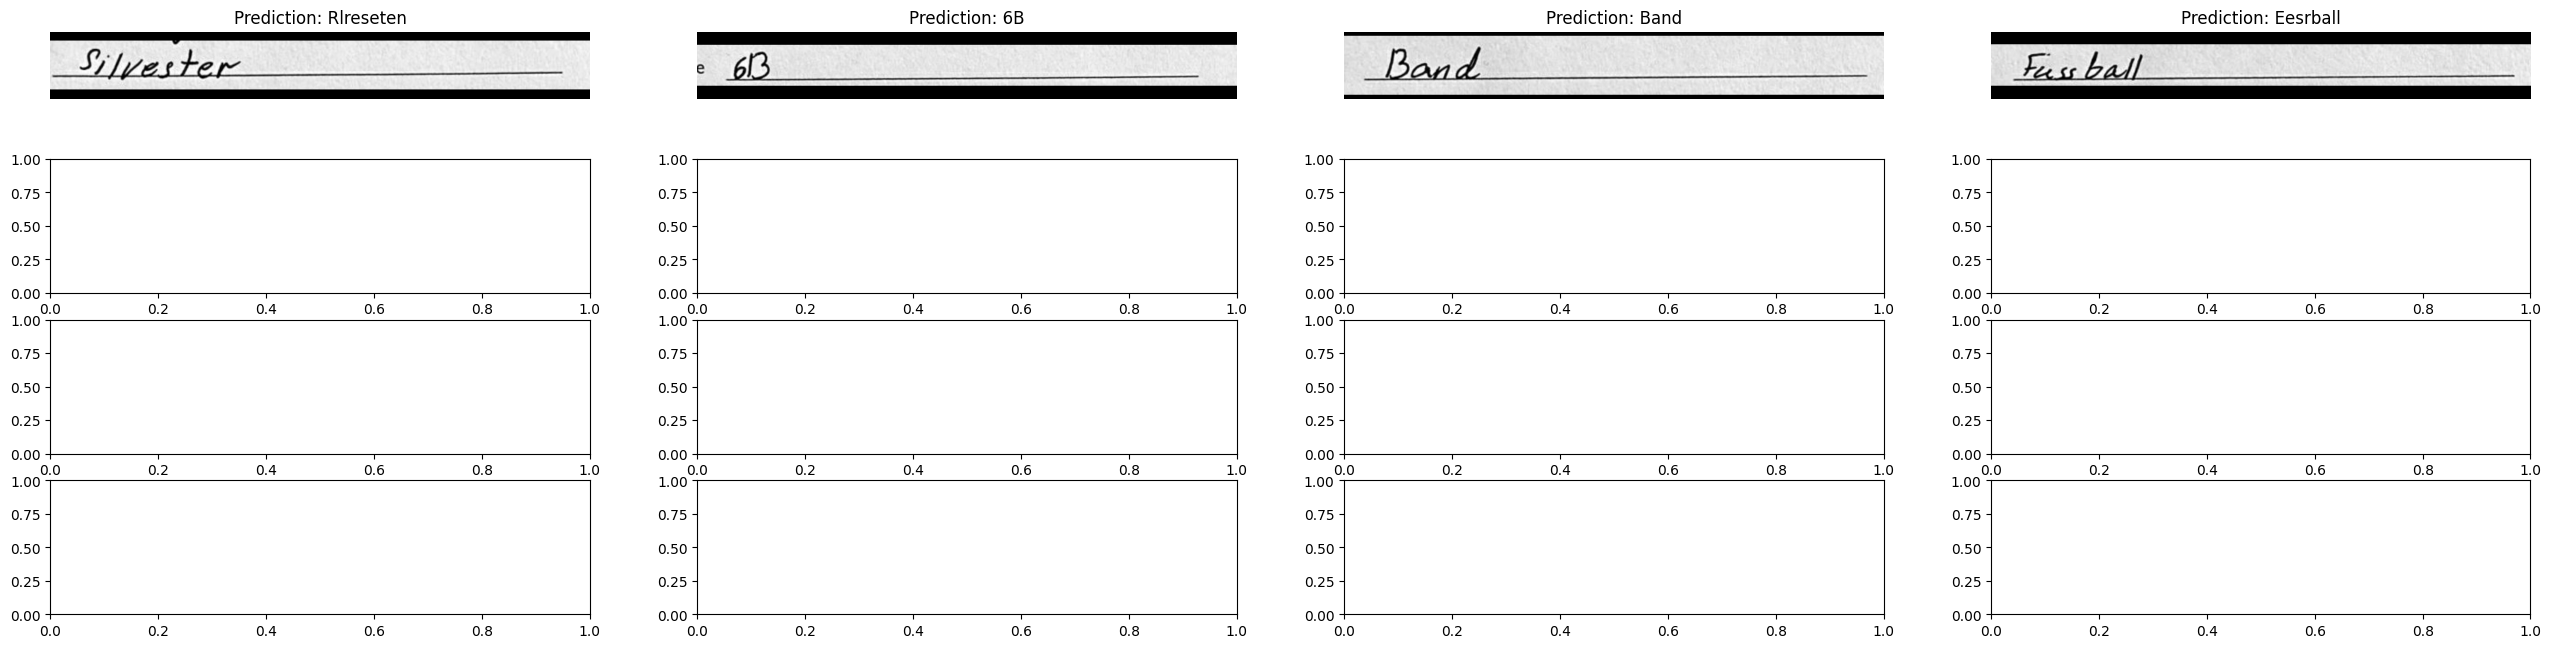

In [24]:
""" Creates a new plot name based on existing names.

This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [25]:
# Saves the model after training if MODEL_SAVE = True
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

    data_to_save = (load_transfer_data.max_len, load_transfer_data.characters)
    import pickle
    with open(os.path.join(model_path, "handwriting_chars.pkl"), 'wb') as file:
        pickle.dump(data_to_save, file)

INFO:tensorflow:Assets written to: c:\Users\jason\GitHubRepos\LectorAI-TextExtraction\models\transferstudent_mafiaboss\assets


INFO:tensorflow:Assets written to: c:\Users\jason\GitHubRepos\LectorAI-TextExtraction\models\transferstudent_mafiaboss\assets
